# LSTM para previsão de casos do COVID-19

Aplicação da rede LSTM desenvolvida e disponibilizada por Luis Ricardo e Marcos Rodrigues.

O código foi organizado e aplicado como requisto para o trabalho de Matemática Computacional (CAP-239-4)

## Definição das funções do modelo


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# univariate data preparation
import numpy as np
from numpy import array
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM,Flatten
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential
from numpy import array 
from numpy import hstack 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math, pickle, csv, os, warnings

path = os.getcwd() # Diretório atual

Using TensorFlow backend.


In [2]:
def organizar_dados(path_input,tipo_analise,pais):
    path = os.path.join(path_input, tipo_analise)
    list_files_analise = os.listdir(path)
    list_files_analise.sort()
    serie_analise = pd.read_csv(os.path.join(path, list_files_analise[0]), 
                                  header = None, engine = 'python')
    select_analise = serie_analise[serie_analise[0] == pais]
    select_analise = select_analise[[0, 2, 3]]
    return select_analise


def split_sequences(sequences, n_steps_in, n_steps_out):
    '''
    Brownlee, J. (2018). Deep Learning for Time Series Forecasting: 
    Predict the Future with MLPs, CNNs and LSTMs in Python. 
    Machine Learning Mastery.
    '''
    X, y = list(), list() 
    for i in range(len(sequences)): 
        #find the end of this pattern 
        end_ix = i + n_steps_in 
        out_end_ix = end_ix + n_steps_out 
        #check if we are beyond the dataset 
        if out_end_ix > len(sequences): 
            break 
        #gather input and output parts of the pattern 
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix:out_end_ix] 
        X.append(seq_x) 
        y.append(seq_y) 
    return X, y

def preparar_dados(dados_covid, n_dias_entrada, n_dias_saida):    
    # choose a number of time steps 
    # covert into input/output
    dados_covid = dados_covid.iloc[:,2]
    dados_covid = np.float64(dados_covid.tolist())
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = dados_covid.reshape(-1, 1)
    data = scaler.fit_transform(data)
    data = data.reshape(len(data),)
    
    X, y = split_sequences(data, n_dias_entrada, n_dias_saida)
    
    inputarray = data[-n_dias_entrada:]
    inputarray = [float(i) for i in inputarray]
    inputarray = np.asarray(inputarray)

    X = np.float64(X)
    y = np.float64(y)    
    return data, X,y, inputarray,scaler


def definir_modelo_lstm_simples(modelo,n_dias_entrada, n_dias_saida):
    n_features = 1
    modelo.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_dias_entrada, n_features)))
    modelo.add(LSTM(200, activation='relu'))
    modelo.add(Dense(n_dias_saida))
    
    modelo.compile(optimizer='adam', loss='mse')
    return modelo

def treinamento(X,y,modelo,epocas,batch):
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # fit model
    history = modelo.fit(X, y, epochs=epocas,batch_size=batch)

    return history

def predict(modelo,inputarray,n_dias_entrada):
    n_features = 1
    x_input = inputarray
    x_input = x_input.reshape((1, n_dias_entrada, n_features))
    yhat = modelo.predict(x_input, verbose=0)
    
    y_future = np.asarray(yhat)
    y_future = yhat.ravel()
    y_future = np.float64(y_future)
    return y_future

def validacao(modelo,n_dias_entrada,inputarray):
    n_features = 1
    x_input = inputarray
    x_input = x_input.reshape((1, n_dias_entrada, n_features))
    yhat = modelo.predict(x_input, verbose=0)
    
    y_future = np.asarray(yhat)
    y_future = yhat.ravel()
    y_future = np.float64(y_future)
    
    return y_future
   
def salvarmodelo(nome,modelo):
    #Salvando
    filename = nome+'.sav'
    pickle.dump(modelo, open(filename, 'wb'))
    

def salvardicionario(nome, history):
    #Salvando Dicionario
    w = csv.writer(open(nome+".csv", "w"))
    for key, val in history.items():
        w.writerow([key, val])    

def carregaModelo(nomeModelo):
    carrega_modelo = pickle.load(open(nomeModelo+'.sav', 'rb'))
    return carrega_modelo

**Função para treinamento automatizado**

In [3]:
def gerarTreinamento_parametros(pais,version,n_entradas,n_saidas, epochs = 50, batch = 1):
    #Parametros: (path_input,tipo_analise,pais)
    daily_cases = organizar_dados(str(os.getcwd()), "Number_Daily_Cases", pais)
    
    #Parametros: (dados_covid, n_dias_entrada, n_dias_saida) -- scaler - toback oringial data
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entradas, n_saidas)
    
    ##Parametros: (modelo,n_dias_entrada, n_dias_saida)
    modelo = Sequential()
    modelo = definir_modelo_lstm_simples(modelo,n_entradas, n_saidas)
    
    #Parametros: (X,y,modelo,epocas,batch)
    history = treinamento(X, y, modelo, epochs, batch)
    #cria dicionario
    history = history.history
    history.keys()
    
    #Salvando Dicionario
    salvardicionario("History_" + pais + "_" + version, history)
    salvarmodelo("Modelo_" + pais + "_" + version, modelo)

**Função para validação**

In [4]:
def geraValidacao(pais, modelo, n_entrada, n_saida, plt_title = "RMSE: {rmse}"):
    daily_cases = organizar_dados(str(os.getcwd()), "Number_Daily_Cases", pais)
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entrada, n_saida)
    
    #Carrega modelo já Treinado
    modelo = carregaModelo(modelo)
    
    list_pred = []
    for i in range(0, 130, n_saida):
        try:
          input_array_test =  np.array(dados_covid[i:(i+n_entrada)])
          if len(input_array_test) < n_entrada:
            input_array_test = np.append(input_array_test,[0],axis = None)
          y_predict_val_test = predict(modelo,input_array_test,n_entrada)
          list_pred.append(y_predict_val_test)
        except:
          warnings.warn("Problema na lógica de separação para predição", RuntimeWarning)
    
    plt.figure()
    concatenado = np.concatenate((list_pred[:]))
    true = dados_covid[n_entrada:len(concatenado)+n_entrada]

    if len(true) < len(concatenado):
        print("entrou condi")
        lim = (len(concatenado) - len(true))
        concatenado = concatenado[0:len(concatenado) - lim]
        
    score_rmse = math.sqrt(mean_squared_error(concatenado, true))
    plt.figure(dpi = 150)
    plt.plot(concatenado,'r--', label = 'Valores preditos')
    plt.plot(true,'b',label = 'Valores reais')
    plt.xlabel('Dias')
    plt.ylabel('Casos diários')
    plt.legend(loc ='upper right')
    plt.title(plt_title.format(rmse = str(round(score_rmse, 4))))
    # plt.title('RMSE: %.4f' % (score_rmse))
    
    return score_rmse

In [5]:
os.makedirs('Number_Daily_Cases', exist_ok = True)

# Funções auxiliares

Esta seção apresenta funções auxiliares para múltiplas execuções. Criado para os testes do trabalho da disciplina de Matemática Computacional (CAP-239-4)

In [6]:
def multiplas_execucoes(pais, padroes_de_entrada, plt_title, epochs_range = None, **kwargs):
  class EpochsChange(RuntimeWarning): ...
  
  def treina_modelo(pais, padroes_de_entrada, plt_title, **kwargs):
    VERSAOT = "v{num}"
    results = {
      'nome_modelo': [],
      'versao': [],
      'entradas': [],
      'rmse': [],
      'epoch': []
    }
    
    for padrao_de_entrada, num in zip(padroes_de_entrada, range(len(padroes_de_entrada))):
      versaot = VERSAOT.format(num = num)
      nmodelo = f"Modelo_{pais}_{versaot}"
      print(nmodelo)

      gerarTreinamento_parametros(pais, versaot, *padrao_de_entrada, **kwargs)
      results['nome_modelo'].append(nmodelo)
      results['versao'].append(versaot)
      results['entradas'].append(padrao_de_entrada)
      
      if kwargs['epochs']:
        results['epoch'].append(kwargs['epochs'])
      else:
        results['epoch'].append(50) # Padrão de épocas

      results['rmse'].append(
          geraValidacao(pais, nmodelo, *padrao_de_entrada, plt_title = plt_title)
      )
    return pd.DataFrame(results)

  if not epochs_range:
    return treina_modelo(pais, padroes_de_entrada, plt_title, **kwargs)
  else:
    warnings.warn("O programa está sendo executado no modo de múltiplas épocas", EpochsChange)

    res = []
    for i in range(*epochs_range):
      res.append(treina_modelo(pais, padroes_de_entrada, plt_title, epochs = i))
    return pd.concat(res)
  raise RuntimeError("Os parâmetros inseridos são inválidos")

# Organização dos dados

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('blueteam_national_update_2020_06_03.csv')
df = df[~df.new_confirmed.isna()]

**Organizando os dados**

Abaixo, os dados são organizados para o formato utilizado no código de LSTM desenvolvido e disponibilizado pelo Luis Ricardo e Marcos Rodrigues

> A estrutura dos dados é organizada e salva em um arquivo, da mesma forma como definido no programa original

In [9]:
national_nt = df[df['state'] == 'RJ']
national_nt = national_nt[national_nt['is_repeated'] == False]

national_nt.set_index('date', inplace = True)
national_nt = national_nt.sort_index()
national_nt = national_nt.groupby(['date', 'state']).sum()
national_nt = national_nt[national_nt.new_confirmed > 0]
national_nt.reset_index(inplace = True)

Adaptando os dados para o formato das ferramentas

In [10]:
serie_cases = pd.DataFrame({
    0: np.repeat('Niteroi', len(national_nt.index)),
    1: np.arange(0, len(national_nt.index)),
    2: national_nt.index,
    3: national_nt.new_confirmed.values
})

serie_cases.to_csv("Number_Daily_Cases/daily-cases-covid-19.csv", index = False)

# Execução do modelo

**Predizendo valores para um país**

In [11]:
gerarTreinamento_parametros("Niteroi", "v1", 20, 10, epochs = 5)

Epoch 1/5
30/30 [==============================] - 1s 48ms/step - loss: 0.0582
Epoch 2/5
30/30 [==============================] - 1s 28ms/step - loss: 0.0525
Epoch 3/5
30/30 [==============================] - 1s 28ms/step - loss: 0.0521
Epoch 4/5
30/30 [==============================] - 1s 27ms/step - loss: 0.0531
Epoch 5/5
30/30 [==============================] - 1s 28ms/step - loss: 0.0526


entrou condi


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


<Figure size 432x288 with 0 Axes>

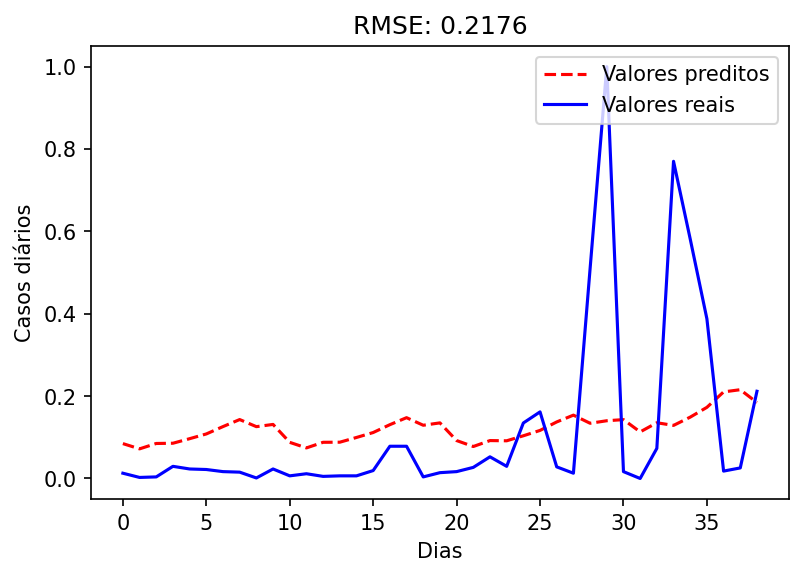

In [12]:
# pontos de entrada
n_entrada = 20
# pontos de saida
n_saida = 10
score_portugal_1 = geraValidacao("Niteroi", "Modelo_Niteroi_v1", n_entrada, n_saida)

# Múltiplas execuções

Nesta seção, múltiplas execuções são feitas para teste dos parâmetros.

## Epoch único

**Minas Gerais**

Modelo_Niteroi_v0
Epoch 1/2
32/32 [==============================] - 2s 52ms/step - loss: 0.0604
Epoch 2/2
32/32 [==============================] - 1s 33ms/step - loss: 0.0576


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v1
Epoch 1/2
23/23 [==============================] - 2s 65ms/step - loss: 0.0858
Epoch 2/2
23/23 [==============================] - 1s 37ms/step - loss: 0.0716


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v2
Epoch 1/2
30/30 [==============================] - 1s 48ms/step - loss: 0.0588
Epoch 2/2
30/30 [==============================] - 1s 28ms/step - loss: 0.0534


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v3
Epoch 1/2
42/42 [==============================] - 2s 37ms/step - loss: 0.0461
Epoch 2/2
42/42 [==============================] - 1s 22ms/step - loss: 0.0460


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi


<Figure size 432x288 with 0 Axes>

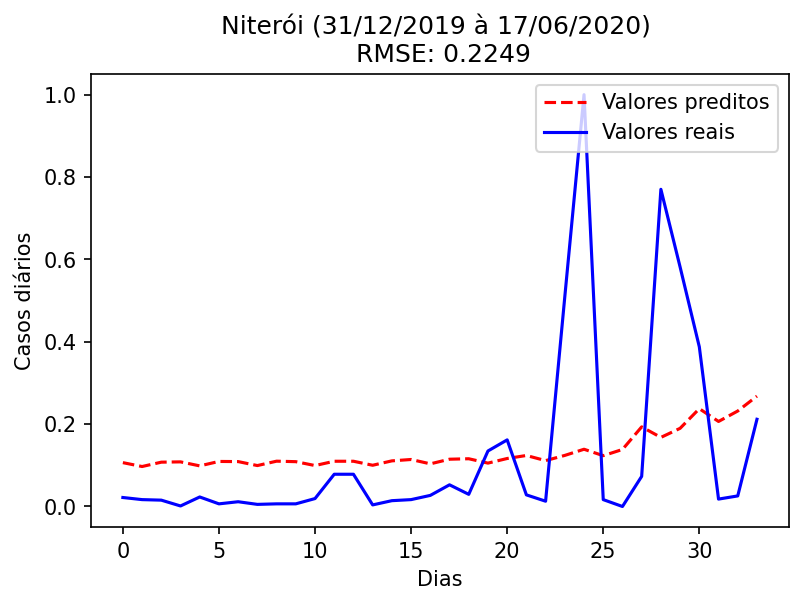

<Figure size 432x288 with 0 Axes>

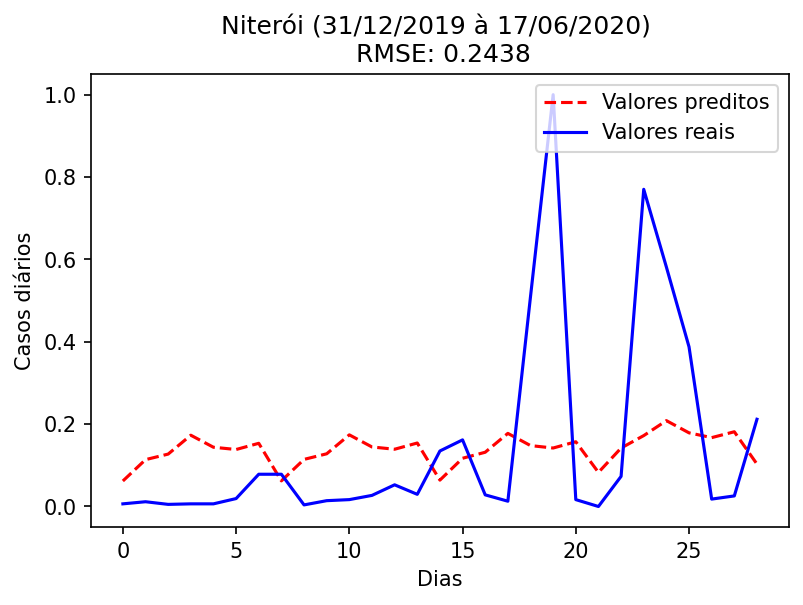

<Figure size 432x288 with 0 Axes>

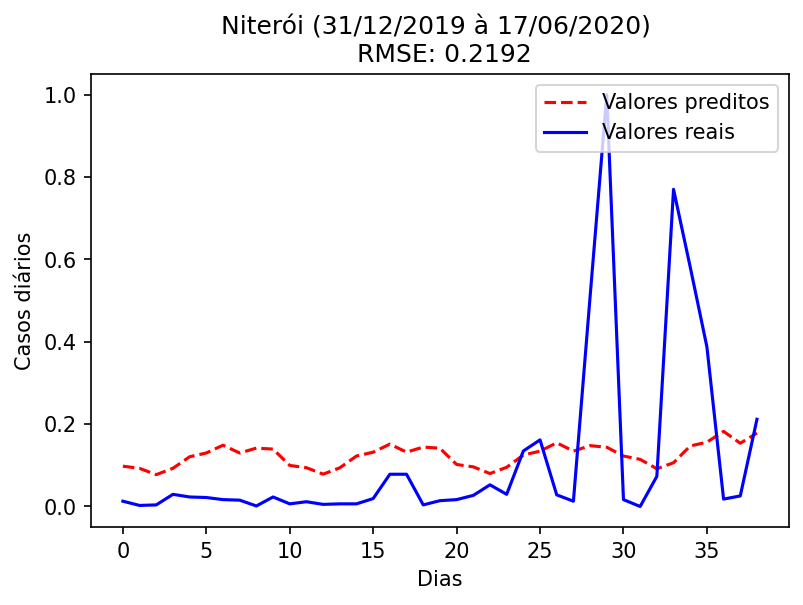

<Figure size 432x288 with 0 Axes>

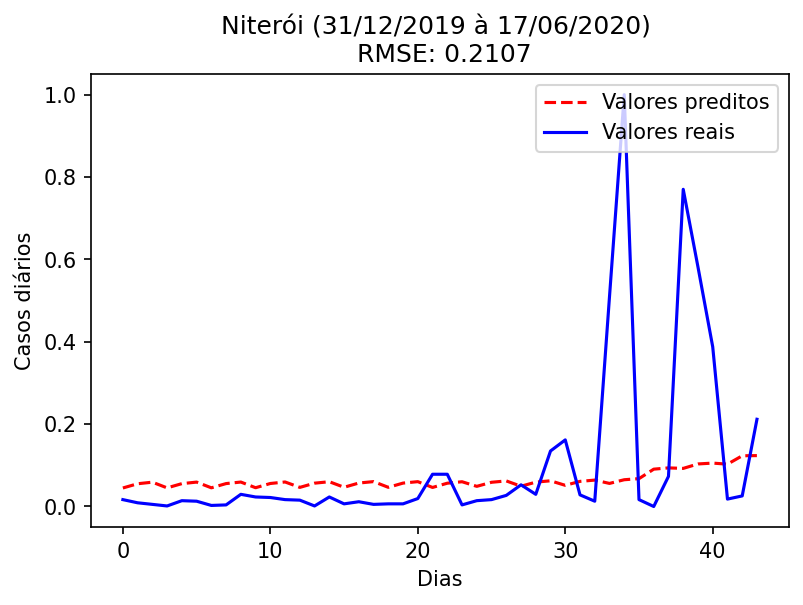

In [13]:
mg_params = multiplas_execucoes("Niteroi", [(10, 7), (20, 7), (30, 7), (20, 10)], 
                                "Niterói (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs = 2)

## Epoch múltiplos

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_Niteroi_v0
Epoch 1/2
32/32 [==============================] - 2s 49ms/step - loss: 0.0601
Epoch 2/2
32/32 [==============================] - 1s 32ms/step - loss: 0.0569


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v1
Epoch 1/2
23/23 [==============================] - 2s 67ms/step - loss: 0.0844
Epoch 2/2
23/23 [==============================] - 1s 38ms/step - loss: 0.0735


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v2
Epoch 1/2
30/30 [==============================] - 1s 46ms/step - loss: 0.0585
Epoch 2/2
30/30 [==============================] - 1s 27ms/step - loss: 0.0548


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v3
Epoch 1/2
42/42 [==============================] - 1s 35ms/step - loss: 0.0517
Epoch 2/2
42/42 [==============================] - 1s 22ms/step - loss: 0.0470


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v0
Epoch 1/3
32/32 [==============================] - 2s 52ms/step - loss: 0.0642
Epoch 2/3
32/32 [==============================] - 1s 33ms/step - loss: 0.0590
Epoch 3/3
32/32 [==============================] - 1s 33ms/step - loss: 0.0567


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v1
Epoch 1/3
23/23 [==============================] - 1s 64ms/step - loss: 0.0828
Epoch 2/3
23/23 [==============================] - 1s 37ms/step - loss: 0.0727
Epoch 3/3
23/23 [==============================] - 1s 38ms/step - loss: 0.0724


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v2
Epoch 1/3
30/30 [==============================] - 2s 51ms/step - loss: 0.0596
Epoch 2/3
30/30 [==============================] - 1s 28ms/step - loss: 0.0532
Epoch 3/3
30/30 [==============================] - 1s 27ms/step - loss: 0.0539


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v3
Epoch 1/3
42/42 [==============================] - 1s 35ms/step - loss: 0.0464
Epoch 2/3
42/42 [==============================] - 1s 22ms/step - loss: 0.0467
Epoch 3/3
42/42 [==============================] - 1s 22ms/step - loss: 0.0458


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v0
Epoch 1/4
32/32 [==============================] - 2s 50ms/step - loss: 0.0646
Epoch 2/4
32/32 [==============================] - 1s 32ms/step - loss: 0.0603
Epoch 3/4
32/32 [==============================] - 1s 33ms/step - loss: 0.0558
Epoch 4/4
32/32 [==============================] - 1s 32ms/step - loss: 0.0558


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v1
Epoch 1/4
23/23 [==============================] - 1s 62ms/step - loss: 0.0829
Epoch 2/4
23/23 [==============================] - 1s 38ms/step - loss: 0.0752
Epoch 3/4
23/23 [==============================] - 1s 38ms/step - loss: 0.0682
Epoch 4/4
23/23 [==============================] - 1s 37ms/step - loss: 0.0704


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Niteroi_v2
Epoch 1/4
30/30 [==============================] - 1s 48ms/step - loss: 0.0593
Epoch 2/4
30/30 [==============================] - 1s 28ms/step - loss: 0.0540
Epoch 3/4
30/30 [==============================] - 1s 27ms/step - loss: 0.0533
Epoch 4/4
30/30 [==============================] - 1s 27ms/step - loss: 0.0517


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi
Modelo_Niteroi_v3
Epoch 1/4
42/42 [==============================] - 1s 35ms/step - loss: 0.0491
Epoch 2/4
42/42 [==============================] - 1s 22ms/step - loss: 0.0462
Epoch 3/4
42/42 [==============================] - 1s 23ms/step - loss: 0.0441
Epoch 4/4
42/42 [==============================] - 1s 22ms/step - loss: 0.0459


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi


<Figure size 432x288 with 0 Axes>

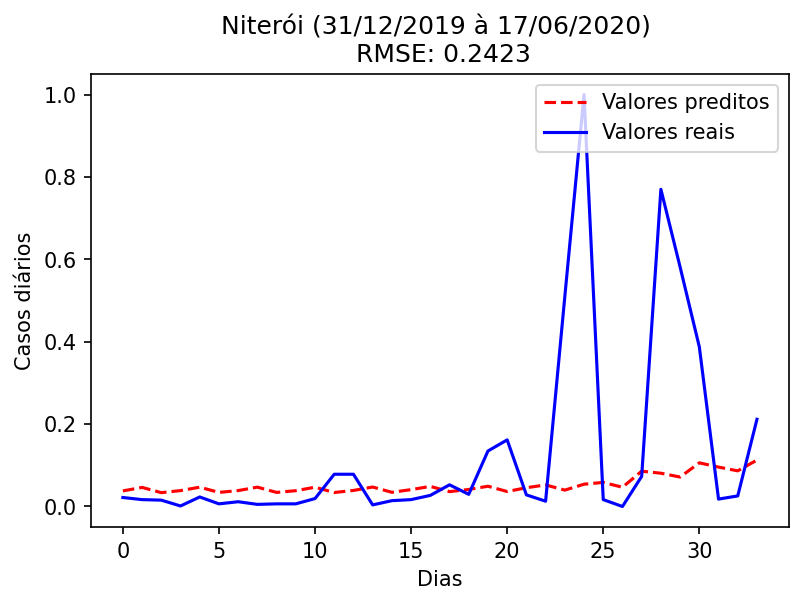

<Figure size 432x288 with 0 Axes>

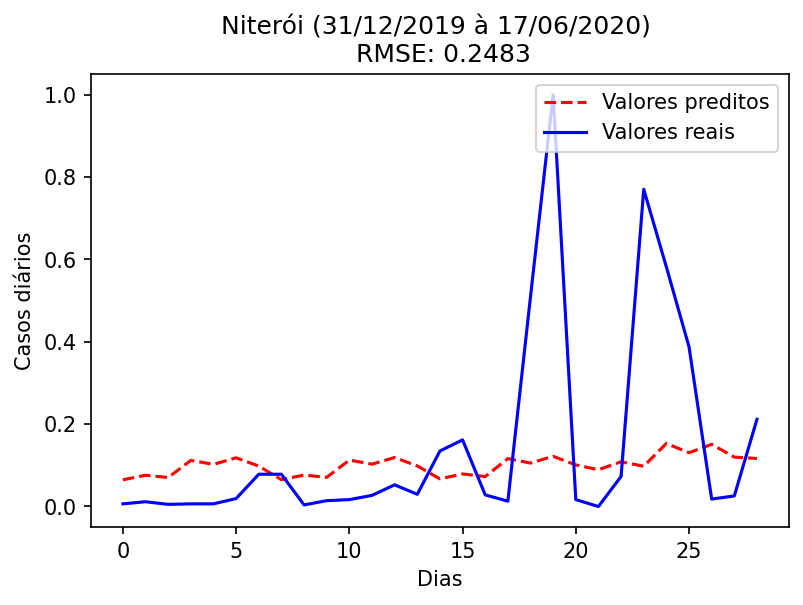

<Figure size 432x288 with 0 Axes>

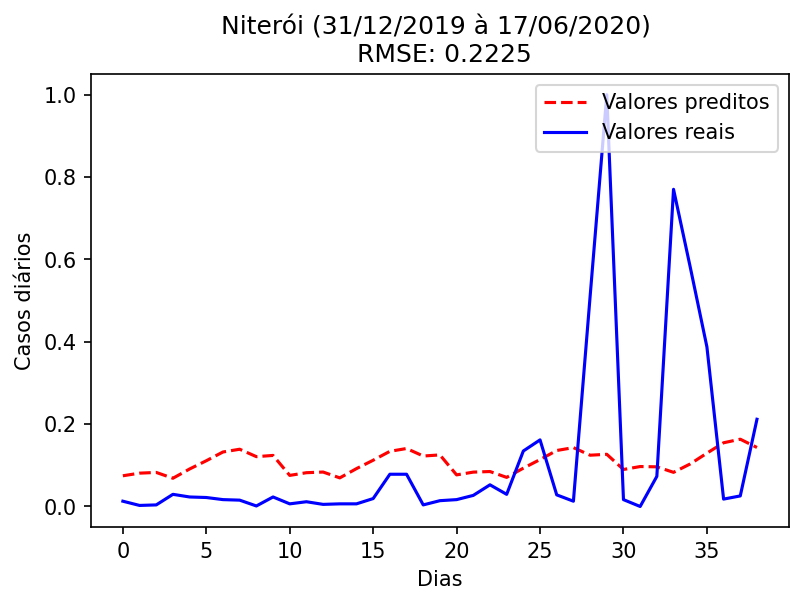

<Figure size 432x288 with 0 Axes>

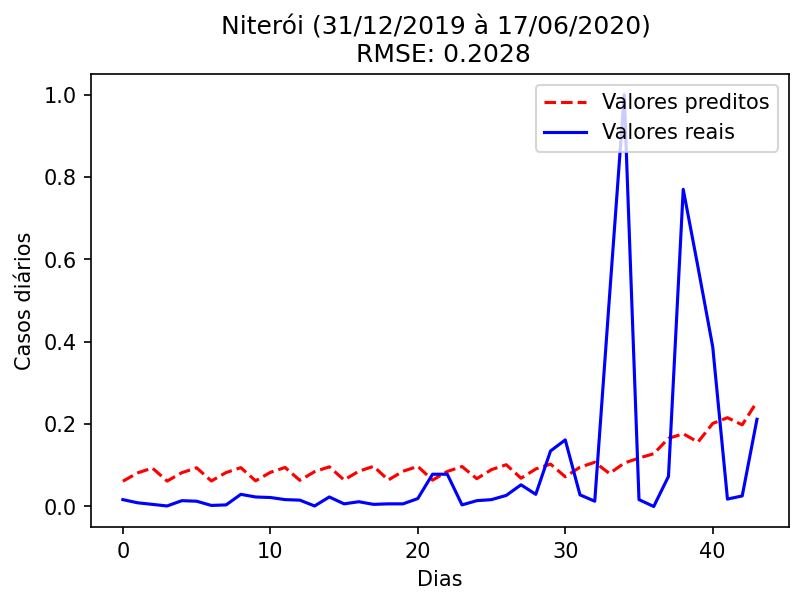

<Figure size 432x288 with 0 Axes>

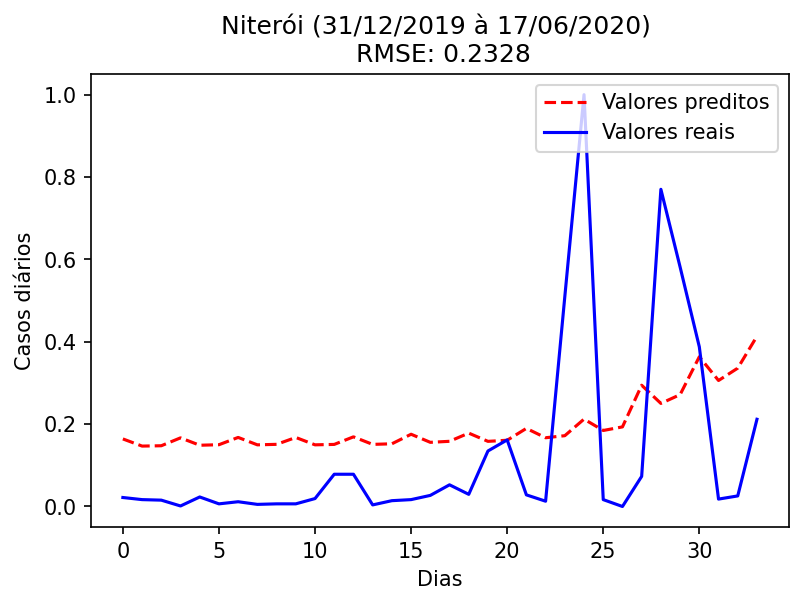

<Figure size 432x288 with 0 Axes>

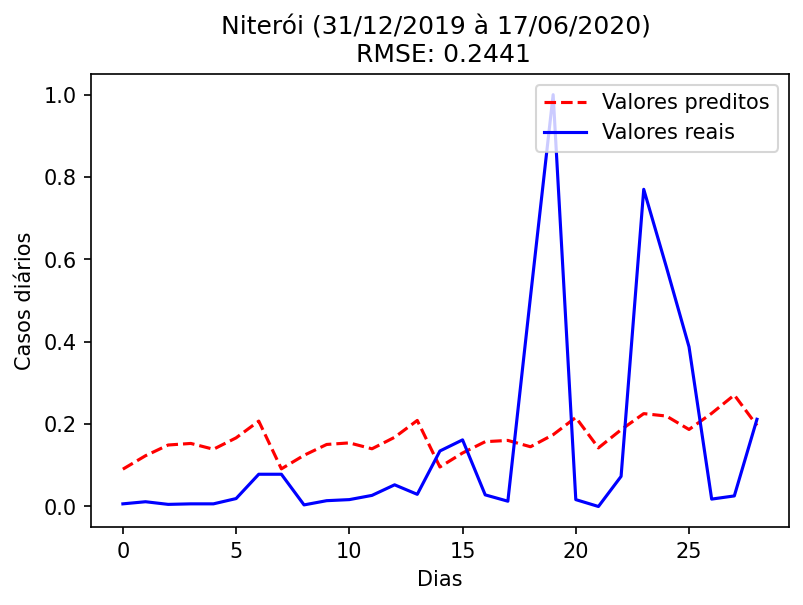

<Figure size 432x288 with 0 Axes>

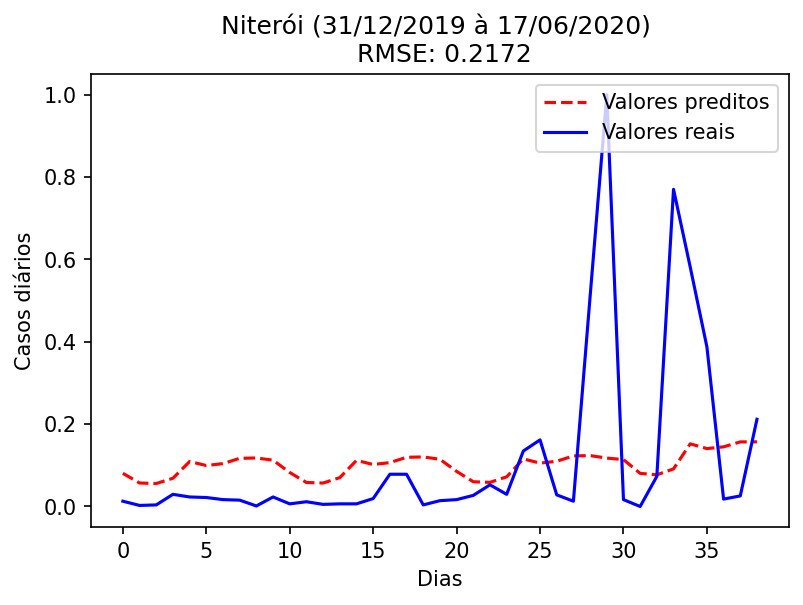

<Figure size 432x288 with 0 Axes>

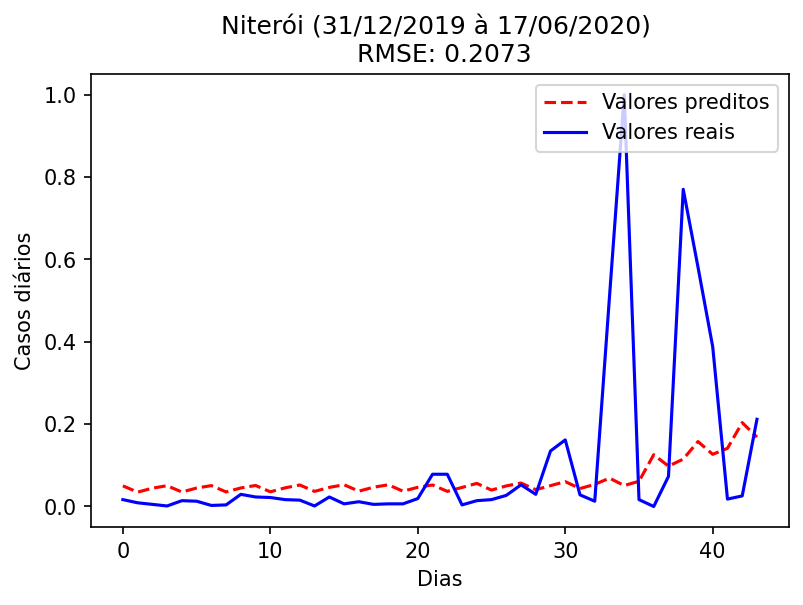

<Figure size 432x288 with 0 Axes>

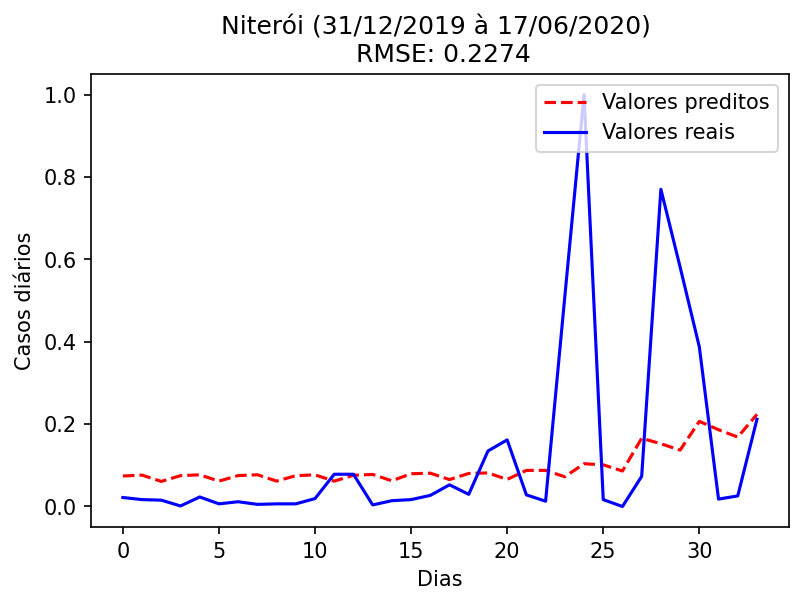

<Figure size 432x288 with 0 Axes>

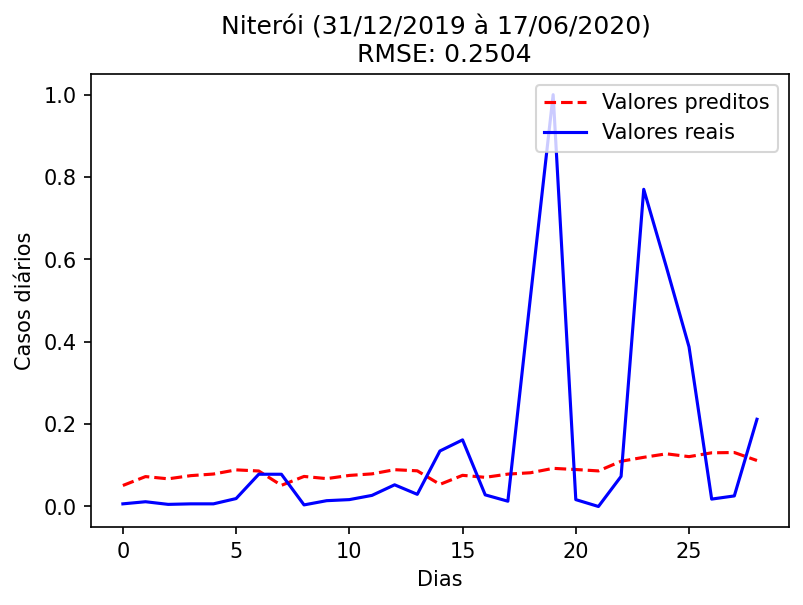

<Figure size 432x288 with 0 Axes>

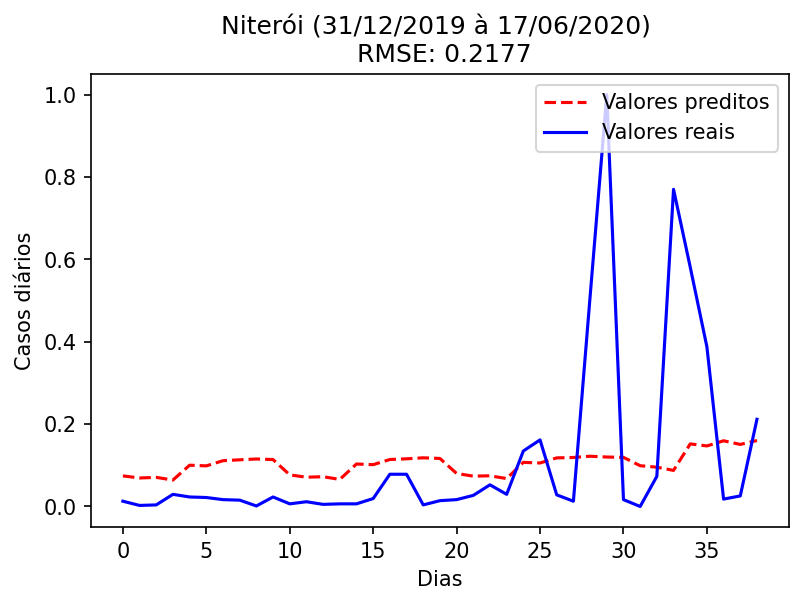

<Figure size 432x288 with 0 Axes>

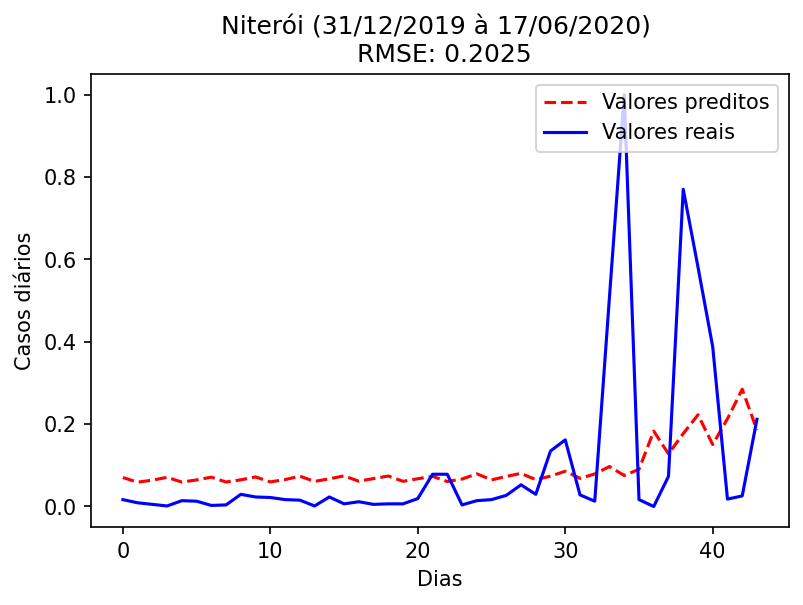

In [14]:
mg_paramsrange = multiplas_execucoes("Niteroi", [(7, 5), (10, 7), (20, 7), (30, 7), (20, 10), (60, 20), (60, 30)], 
                                "Niterói (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", 
                                epochs_range = (10, 50))